<a href="https://colab.research.google.com/github/Sompote/RIC_paper/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This code is for a transformer for predict RIC results combindnation of LSTM and CON1D together to predict RIC
*   The feature was add to encoding data
*   initial qc value is in [:,:,0]




In [1]:
#Transformer Autoencoder to predict RIC combind model by Dr. Sompote Youwai 2023
import numpy as np
import pandas as pd

# Import libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd



df = pd.read_excel('/content/drive/MyDrive/RIC/data_17aug.xlsx')
data=np.array(df)
X=data[:,1:29]
Y=data[:,34:62]
x_feature=data[:,29:32]




In [2]:
def movingavarage(array,window):
  X = np.apply_along_axis(lambda x: np.convolve(x, np.ones(window)/window, mode='valid'), axis=1, arr=array)
  return X
#scale data
X_train=X
Y_train=Y
sc_y=StandardScaler()
sc = StandardScaler()
sc_f=StandardScaler()
X_feature=x_feature
X_train=X

x_train = sc.fit_transform(X_train)
y_train=sc_y.fit_transform(Y_train)
x_feature=sc_f.fit_transform(X_feature)

X_train_smooth=movingavarage(x_train,3)
Y_train_smooth=movingavarage(y_train,3)


In [3]:
X_train_CNN=np.zeros((X.shape[0],X.shape[1],X_feature.shape[1]+1))
X_train_CNN[:,:,0]=x_train
for i in range(0,(X.shape[0])):
  X_train_CNN[i,:,1]=x_feature[i,0]
  X_train_CNN[i,:,2]=x_feature[i,1]
  X_train_CNN[i,:,3]=x_feature[i,2]

In [4]:
#split data
X_train, X_test, X_feature_train, X_feature_test, Y_train, Y_test = train_test_split(X_train_CNN, x_feature, y_train, random_state=1,test_size=0.2)




In [6]:
#Model generation part
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, concatenate,Reshape, Dropout,Bidirectional
from keras.layers import MaxPooling1D
from keras.layers import LSTM, Dense
from tensorflow.keras.metrics import MeanAbsolutePercentageError
#from attention import Attention





def CNN_model(cnn_input_shape):
  # Create the CNN model
  cnn_input = Input(shape=cnn_input_shape,name='CNN_input')
  cnn_output = Conv1D(filters=128, kernel_size=4, activation='sigmoid')(cnn_input)
  cnn_output = Conv1D(filters=64, kernel_size=2, activation='sigmoid')(cnn_output)
  #cnn_output = Attention(units=32)(cnn_output)

  cnn_output = Flatten()(cnn_output)
  layer = Dropout(0.2)(cnn_output)

  cnn_output = Dense(50, activation='linear')(layer)
  cnn_model = Model(inputs=cnn_input, outputs=cnn_output,name='CNN_model')
  return cnn_model


def LSTM_model(dense_input_shape):
  # Create the dense model
  # Use the function parameter as the input shape
  dense_input = Input(shape=dense_input_shape,name='LSTM_input')
  dense_output = LSTM(200,return_sequences=True)(dense_input)
  #dense_output = Attention(units=32)(dense_output)
  layer = Flatten()(dense_output)
  layer = Dropout(0.2)(layer)

  dense_output = Dense(200, activation='sigmoid')(layer)
  dense_output = Dense(50, activation='linear')(layer)
  dense_model = Model(inputs=dense_input, outputs=dense_output,name='LSTM_model')
  return dense_model

def encoding_model(LSTM_model,latent_dim):

  combined_input_LSTM = LSTM_model.output
  layer=Dense(200, activation='sigmoid')(combined_input_LSTM)
  combined_output = Dense(latent_dim, activation='linear')(layer)
  combined_model = Model(inputs=[LSTM_model.input], outputs=combined_output,name='encoding_model')
  return combined_model


def decoding_model(latent_dim,time_step):
  inputs_l = Input(shape=latent_dim, name='latent')

  layer=Dense(200, activation='sigmoid')(inputs_l)
  layer=Dense(100, activation='sigmoid')(layer)

  dense_output = Dense(time_step, activation='linear')(layer)
  output=dense_output
  model = Model(inputs_l, outputs=output,name='decoding_model')
  return model

def transformer(encoding_model,decoding_model,feature_dim):

  input_l=encoding_model.output
  print(input_l)
  outputs = decoding_model(input_l)
  print(outputs)
  model = Model(inputs=encoding_model.input, outputs=outputs,name='Transformer')
  return model



# Compile and summarize the combined model
#Main program

dense_input_shape = (X_train.shape[1])
cnn_input_shape = (X_train.shape[1],X_train.shape[2])
LSTM_input_shape=(X_train.shape[1],X_train.shape[2])


feature_dim=X_feature.shape[1]
latent_dim=16
time_step=Y_train.shape[1]

model_lstm= LSTM_model(LSTM_input_shape)
model_CNN=CNN_model(LSTM_input_shape)

model_encoding=encoding_model(model_lstm,latent_dim)
model_decoding=decoding_model(latent_dim,time_step)
model_transform=transformer(model_encoding,model_decoding,feature_dim)
model_transform.compile(optimizer='adam', loss='mse', metrics=['mae','mape'])
model_transform.summary()


from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=6,restore_best_weights=True)

history=model_transform.fit(X_train, Y_train, epochs=2000, batch_size=10,validation_data=([X_test], Y_test))

KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='dense_10/BiasAdd:0', description="created by layer 'dense_10'")
KerasTensor(type_spec=TensorSpec(shape=(None, 28), dtype=tf.float32, name=None), name='decoding_model/dense_13/BiasAdd:0', description="created by layer 'decoding_model'")
Model: "Transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_input (InputLayer)     [(None, 28, 4)]           0         
                                                                 
 lstm (LSTM)                 (None, 28, 200)           164000    
                                                                 
 flatten_1 (Flatten)         (None, 5600)              0         
                                                                 
 dropout_1 (Dropout)         (None, 5600)              0         
                                                              

In [ ]:
def mape(y_true, y_pred):
  mape=np.mean(np.abs((Y - y_pred)/Y))*100
  # return mean of percentage errors
  return mape


def mae(y_true, y_pred):
  mae=np.mean(np.abs(Y - y_pred))
  # return mean of percentage errors
  return mae

y=model_transform.predict([X_train_CNN])
y_pred=sc_y.inverse_transform(y)

mape=mape(Y,y_pred)
mae=mae(Y,y_pred)

print('MAPE=', mape)
print('MAPE=', mae)


1/1 [==============================] - 0s 128ms/step
MAPE= 6.0012504329239125
MAPE= 0.2939379899051233


In [ ]:
Y

array([[ 9.93243243e+00,  9.93243243e+00,  1.07432432e+01,
         1.33783784e+01,  1.58108108e+01,  1.43918919e+01,
         1.23648649e+01,  1.37837838e+01,  1.19594595e+01,
         3.64864865e+00,  1.01351351e+00,  6.08108108e-01,
         1.62162162e+00,  3.04054054e+00,  2.22972973e+00,
         2.02702703e+00,  2.43243243e+00,  2.22972973e+00,
         3.85135135e+00,  3.44594595e+00,  2.43243243e+00,
         2.22972973e+00,  4.05405405e+00,  4.05405405e+00,
         5.47297297e+00,  6.89189189e+00,  9.12162162e+00,
         1.23648649e+01],
       [ 9.28057554e+00,  1.25179856e+01,  1.53237410e+01,
         1.31654676e+01,  8.63309353e+00,  7.33812950e+00,
         9.71223022e+00,  1.46762590e+01,  4.74820144e+00,
         1.07913669e+00, -1.77635684e-15,  1.94244604e+00,
         2.58992806e+00,  2.37410072e+00,  2.15827338e+00,
         1.51079137e+00,  2.37410072e+00,  2.58992806e+00,
         2.80575540e+00,  2.58992806e+00,  2.80575540e+00,
         2.15827338e+00,  3.23

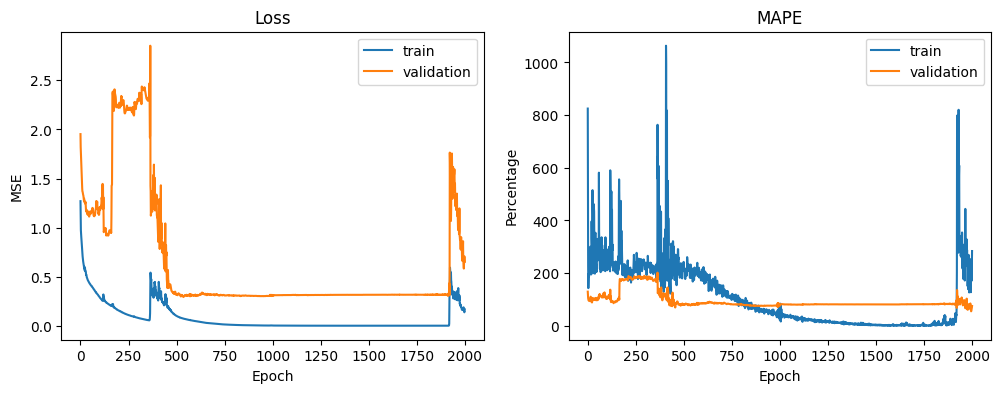

In [ ]:

# plot the loss and mape for train and validation sets
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mape'], label='train')
plt.plot(history.history['val_mape'], label='validation')
plt.title('MAPE')
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.legend()

plt.show()

Model: "Transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CNN_input (InputLayer)      [(None, 28, 4)]           0         
                                                                 
 conv1d (Conv1D)             (None, 25, 128)           2176      
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 64)            16448     
                                                                 
 flatten_9 (Flatten)         (None, 1536)              0         
                                                                 
 dense_63 (Dense)            (None, 50)                76850     
                                                                 
 dense_64 (Dense)            (None, 200)               10200     
                                                                 
 dense_65 (Dense)            (None, 16)                

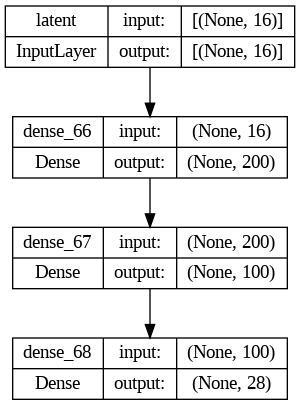

In [ ]:
# plot and save your model
import tensorflow as tf
model_transform.summary()
img_file = 'model_transform.png'
tf.keras.utils.plot_model(model_transform, to_file=img_file, show_shapes=True, show_layer_names=True)
img_file = 'model_decode.png'
tf.keras.utils.plot_model(model_decoding, to_file=img_file, show_shapes=True, show_layer_names=True)

In [ ]:
#validation
x_predictn=np.zeros((1,28))
#x_predictn[0,:]=[10,18,18,20,25,18,20,18,5,2,10,9,10,5,8,6,6,4,7,12,23,24,25,25,54,27,23]
x_predictn[0,:]=data[15,1:29]
X_predict = sc.transform(x_predictn)
x_feature=np.zeros((1,3))
x_feature[0,0]=200 #blow
x_feature[0,1]=18 #fine
x_feature[0,2]=3 #thickness
X_feature = sc_f.transform(x_feature)

x_cal=np.zeros((1,time_step,4))
x_cal[:,:,0]=X_predict
x_cal[:,:,1]=X_feature[0,0]
x_cal[:,:,2]=X_feature[0,1]
x_cal[:,:,3]=X_feature[0,2]
y=model_transform.predict([X_feature,x_cal,x_cal])
y=sc_y.inverse_transform(y)
print(y)
#plot


1/1 [==============================] - 0s 45ms/step
[[ 9.190448  17.016558  17.261732  22.492096  19.09089   21.615244
  18.360254  18.89261   16.29926   14.670464  13.147469  10.391664
   7.6278677  7.136345   5.327044   1.1572992  2.1025267  1.2308354
   1.5166115  1.9782487  2.7969334  3.024237   2.8978884  2.9784858
   2.4179387  2.3918846  2.8478818  4.075197 ]]


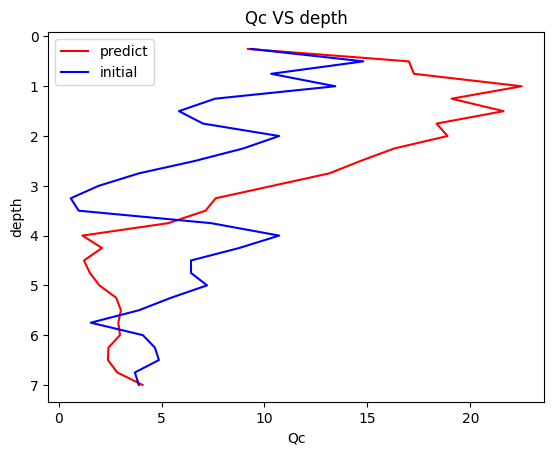

In [ ]:
import matplotlib.pyplot as plt

# Define the x-axis and corresponding y-axis values as lists

ydist=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6,6.25,6.5,6.75,7]


# Plot them on canvas using plt.plot() function
plt.plot(y[0,:], ydist,color='red',label='predict')
plt.plot(x_predictn[0,:], ydist,color='blue',label='initial')
plt.legend()


# Give a name to x-axis and y-axis using plt.xlabel() and plt.ylabel() functions
plt.xlabel("Qc")
plt.ylabel("depth")

# Give a title to your plot using plt.title() function
plt.title("Qc VS depth")
# Get the current axes instance
ax = plt.gca()

# Invert the y-axis
ax.invert_yaxis()

# Finally, to view your plot, we use plt.show() function
plt.show()